In [1]:
import pandas as pd
import numpy as np
import datetime
import time

In [2]:
df = pd.read_parquet('last_assembled_df.parquet')
df

,common_id,event_date,event_timestamp,action_time,vacancy_id_,cookie_id,user_id,event_type,rating
0,1,2022-08-30,1661866548,0,153975,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,preview_click_vacancy,0
1,1,2022-08-30,1661866548,11,153975,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,show_vacancy,0
2,1,2022-08-30,1661866559,0,182445,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,show_vacancy,0
3,1,2022-08-30,1661866559,5,182445,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,preview_click_vacancy,0
4,1,2022-08-30,1661866564,0,182445,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,show_vacancy,0
...,...,...,...,...,...,...,...,...,...
12292583,367641,2022-08-22,1661164755,0,160164,ffffdb17f45b4032b386d691d52e6c00,None,preview_click_vacancy,0
12292584,367641,2022-08-22,1661164755,791,160164,ffffdb17f45b4032b386d691d52e6c00,None,preview_click_contacts,1
12292585,367641,2022-08-22,1661165546,1,185412,ffffdb17f45b4032b386d691d52e6c00,None,preview_click_vacancy,0
12292586,367641,2022-08-22,1661165547,5,185412,ffffdb17f45b4032b386d691d52e6c00,None,show_vacancy,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12212868 entries, 0 to 12292587
Data columns (total 9 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   common_id        int64 
 1   event_date       object
 2   event_timestamp  int64 
 3   action_time      int32 
 4   vacancy_id_      int64 
 5   cookie_id        object
 6   user_id          object
 7   event_type       object
 8   rating           int64 
dtypes: int32(1), int64(4), object(4)
memory usage: 885.2+ MB


In [7]:
#Создаем список уникальных собвеий
qw = df['event_type'].value_counts()
events = qw.index.to_list()
events


['show_vacancy',
 'preview_click_vacancy',
 'click_response',
 'click_contacts',
 'preview_click_response',
 'click_favorite',
 'preview_click_favorite',
 'preview_click_contacts',
 'click_phone',
 'preview_click_phone']

In [8]:
features_events = ['show_vacancy', 'preview_click_vacancy', 'click_favorite', 'preview_click_favorite']
features_events

['show_vacancy',
 'preview_click_vacancy',
 'click_favorite',
 'preview_click_favorite']

In [9]:
# Целевые события
target_events = ['click_response', 'click_contacts', 'preview_click_response', 'preview_click_contacts',
                 'click_phone', 'preview_click_phone']
target_events

['click_response',
 'click_contacts',
 'preview_click_response',
 'preview_click_contacts',
 'click_phone',
 'preview_click_phone']

In [10]:
df.groupby(['event_type'])['action_time'].sum().sort_values(ascending=False)


event_type
show_vacancy              190519723512
preview_click_vacancy      71659030964
click_response             13077244045
click_contacts             10807768794
preview_click_response      8053389274
click_favorite              5564062096
click_phone                 3895616630
preview_click_favorite      3256913523
preview_click_contacts      3129029366
preview_click_phone          883434011
Name: action_time, dtype: int64

In [11]:
 df.groupby('common_id')['vacancy_id_'].apply(list)

common_id
1         [153975, 153975, 182445, 182445, 182445, 18244...
2         [192850, 192850, 230581, 230581, 250327, 25032...
3         [226832, 226832, 226832, 226832, 122287, 12228...
4         [243795, 209629, 209629, 135961, 138688, 13850...
5                  [242642, 242642, 242642, 242642, 242642]
                                ...                        
367637     [210628, 203404, 235862, 235862, 239893, 239893]
367638    [105008, 105008, 125883, 125883, 132245, 13224...
367639    [115949, 115949, 115949, 127277, 127277, 12727...
367640    [102931, 102931, 102931, 102931, 102931, 15598...
367641    [150843, 150843, 107893, 107893, 107125, 10712...
Name: vacancy_id_, Length: 366734, dtype: object

In [12]:
# Скопируем в новый столюец 'not_target_event' нецелевые события
df['not_target_event'] = np.where(df['event_type'].isin(features_events), df['event_type'], 0)
# В новый столбец 'target_event' целевые события отметим 1, нецелевые 0
df['target_event'] = np.where(df['event_type'].isin(target_events), 1, 0)
# В столбец 'nonrel_action_time' скопируем время потраченное на нецелевые действия
df['nonrel_action_time'] = np.where(df['event_type'].isin(features_events), df['action_time'], 0)

df

,common_id,event_date,event_timestamp,action_time,vacancy_id_,cookie_id,user_id,event_type,rating,not_target_event,target_event,nonrel_action_time
0,1,2022-08-30,1661866548,0,153975,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,preview_click_vacancy,0,preview_click_vacancy,0,0
1,1,2022-08-30,1661866548,11,153975,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,show_vacancy,0,show_vacancy,0,11
2,1,2022-08-30,1661866559,0,182445,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,show_vacancy,0,show_vacancy,0,0
3,1,2022-08-30,1661866559,5,182445,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,preview_click_vacancy,0,preview_click_vacancy,0,5
4,1,2022-08-30,1661866564,0,182445,0000c4548c3944c08972bbdc1fa4eb85,2eb30fab80244cdebbafd5ed096bc08f,show_vacancy,0,show_vacancy,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
12292583,367641,2022-08-22,1661164755,0,160164,ffffdb17f45b4032b386d691d52e6c00,None,preview_click_vacancy,0,preview_click_vacancy,0,0
12292584,367641,2022-08-22,1661164755,791,160164,ffffdb17f45b4032b386d691d52e6c00,None,preview_click_contacts,1,0,1,0
12292585,367641,2022-08-22,1661165546,1,185412,ffffdb17f45b4032b386d691d52e6c00,None,preview_click_vacancy,0,preview_click_vacancy,0,1
12292586,367641,2022-08-22,1661165547,5,185412,ffffdb17f45b4032b386d691d52e6c00,None,show_vacancy,0,show_vacancy,0,5


In [13]:
not_target = df.groupby(['common_id', 'vacancy_id_'])['not_target_event'].apply(list)
not_target_df = pd.DataFrame(not_target)
not_target_df

not_target_event
common_id vacancy_id_                                                   
1         137659                   [show_vacancy, preview_click_vacancy]
          153975                   [preview_click_vacancy, show_vacancy]
          174953       [preview_click_vacancy, show_vacancy, click_fa...
          176171                   [preview_click_vacancy, show_vacancy]
          182445       [show_vacancy, preview_click_vacancy, show_vac...
...                                                                  ...
367641    107125                [preview_click_vacancy, show_vacancy, 0]
          107893                              [preview_click_vacancy, 0]
          150843                              [preview_click_vacancy, 0]
          160164                              [preview_click_vacancy, 0]
          185412                [preview_click_vacancy, show_vacancy, 0]

[4696085 rows x 1 columns]

In [14]:
target = df.groupby(['common_id', 'vacancy_id_'])['target_event'].apply(list)
target_df = pd.DataFrame(target)
target_df

target_event
common_id vacancy_id_              
1         137659             [0, 0]
          153975             [0, 0]
          174953          [0, 0, 0]
          176171             [0, 0]
          182445       [0, 0, 0, 0]
...                             ...
367641    107125          [0, 0, 1]
          107893             [0, 1]
          150843             [0, 1]
          160164             [0, 1]
          185412          [0, 0, 1]

[4696085 rows x 1 columns]

In [15]:
merged_df = not_target_df.merge(target_df, left_on=['common_id', 'vacancy_id_'], right_on=['common_id', 'vacancy_id_'])
merged_df

not_target_event  \
common_id vacancy_id_                                                      
1         137659                   [show_vacancy, preview_click_vacancy]   
          153975                   [preview_click_vacancy, show_vacancy]   
          174953       [preview_click_vacancy, show_vacancy, click_fa...   
          176171                   [preview_click_vacancy, show_vacancy]   
          182445       [show_vacancy, preview_click_vacancy, show_vac...   
...                                                                  ...   
367641    107125                [preview_click_vacancy, show_vacancy, 0]   
          107893                              [preview_click_vacancy, 0]   
          150843                              [preview_click_vacancy, 0]   
          160164                              [preview_click_vacancy, 0]   
          185412                [preview_click_vacancy, show_vacancy, 0]   

                       target_event  
common_id vacancy_id_                
1         137659             [0, 0]  
          153975             [0, 0]  
          174953          [0, 0, 0]  
          176171             [0, 0]  
          182445       [0, 0, 0, 0]  
...                             ...  
367641    107125          [0, 0, 1]  
          107893             [0, 1]  
          150843             [0, 1]  
          160164             [0, 1]  
          185412          [0, 0, 1]  

[4696085 rows x 2 columns]

In [16]:
df['target_event'].isnull().sum()

0

In [17]:
df.groupby(['common_id', 'vacancy_id_'])['event_type'].apply(list)


common_id  vacancy_id_
1          137659                     [show_vacancy, preview_click_vacancy]
           153975                     [preview_click_vacancy, show_vacancy]
           174953         [preview_click_vacancy, show_vacancy, click_fa...
           176171                     [preview_click_vacancy, show_vacancy]
           182445         [show_vacancy, preview_click_vacancy, show_vac...
                                                ...                        
367641     107125         [preview_click_vacancy, show_vacancy, click_co...
           107893           [preview_click_vacancy, preview_click_contacts]
           150843           [preview_click_vacancy, preview_click_contacts]
           160164           [preview_click_vacancy, preview_click_contacts]
           185412         [preview_click_vacancy, show_vacancy, click_co...
Name: event_type, Length: 4696085, dtype: object

In [18]:
df.groupby(['common_id', 'vacancy_id_'])['action_time'].sum()

common_id  vacancy_id_
1          137659            18
           153975            11
           174953            48
           176171             6
           182445            18
                          ...  
367641     107125         10228
           107893            94
           150843            40
           160164           791
           185412             6
Name: action_time, Length: 4696085, dtype: int32

In [19]:
sec = df.groupby(['common_id', 'vacancy_id_'])['nonrel_action_time'].sum()
sec_df = pd.DataFrame(sec)
sec_df

nonrel_action_time
common_id vacancy_id_                    
1         137659                       18
          153975                       11
          174953                       48
          176171                        6
          182445                       18
...                                   ...
367641    107125                    10105
          107893                        0
          150843                        0
          160164                        0
          185412                        6

[4696085 rows x 1 columns]

In [20]:
merged_df = merged_df.merge(sec_df, left_on=['common_id', 'vacancy_id_'], right_on=['common_id', 'vacancy_id_'])
merged_df

not_target_event  \
common_id vacancy_id_                                                      
1         137659                   [show_vacancy, preview_click_vacancy]   
          153975                   [preview_click_vacancy, show_vacancy]   
          174953       [preview_click_vacancy, show_vacancy, click_fa...   
          176171                   [preview_click_vacancy, show_vacancy]   
          182445       [show_vacancy, preview_click_vacancy, show_vac...   
...                                                                  ...   
367641    107125                [preview_click_vacancy, show_vacancy, 0]   
          107893                              [preview_click_vacancy, 0]   
          150843                              [preview_click_vacancy, 0]   
          160164                              [preview_click_vacancy, 0]   
          185412                [preview_click_vacancy, show_vacancy, 0]   

                       target_event  nonrel_action_time  
common_id vacancy_id_                                    
1         137659             [0, 0]                  18  
          153975             [0, 0]                  11  
          174953          [0, 0, 0]                  48  
          176171             [0, 0]                   6  
          182445       [0, 0, 0, 0]                  18  
...                             ...                 ...  
367641    107125          [0, 0, 1]               10105  
          107893             [0, 1]                   0  
          150843             [0, 1]                   0  
          160164             [0, 1]                   0  
          185412          [0, 0, 1]                   6  

[4696085 rows x 3 columns]

In [21]:
merged_df.not_target_event

common_id  vacancy_id_
1          137659                     [show_vacancy, preview_click_vacancy]
           153975                     [preview_click_vacancy, show_vacancy]
           174953         [preview_click_vacancy, show_vacancy, click_fa...
           176171                     [preview_click_vacancy, show_vacancy]
           182445         [show_vacancy, preview_click_vacancy, show_vac...
                                                ...                        
367641     107125                  [preview_click_vacancy, show_vacancy, 0]
           107893                                [preview_click_vacancy, 0]
           150843                                [preview_click_vacancy, 0]
           160164                                [preview_click_vacancy, 0]
           185412                  [preview_click_vacancy, show_vacancy, 0]
Name: not_target_event, Length: 4696085, dtype: object

In [22]:
final_df = merged_df.copy()

In [23]:
llst = []
llst = final_df['target_event'].to_list()
llst

[[0, 0],
 [0, 0],
 [0, 0, 0],
 [0, 0],
 [0, 0, 0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0],
 [0, 0, 1],
 [0, 0, 0, 1],
 [0, 0, 1],
 [0],
 [0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0],
 [0],
 [0],
 [0, 1, 0, 0],
 [0, 0],
 [1],
 [0, 0],
 [0, 0, 0, 0, 0],
 [0],
 [0],
 [0, 0, 0],
 [0, 0],
 [0, 0, 0, 0, 0, 0],
 [0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0],
 [0, 0, 0],
 [0],
 [0, 0],
 [0, 0, 0],
 [0, 0, 0, 0],
 [0, 0],
 [0],
 [0, 0, 1],
 [0, 0],
 [0, 0],
 [1],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0],
 [0, 0, 0],
 [0, 0],
 [0, 0],
 [0],
 [1],
 [0],
 [0, 0],
 [0, 0],
 [0, 0],
 [1],
 [0],
 [0, 0],
 [0, 0, 0, 0],
 [0, 0, 0],
 [0, 0, 1, 0, 0],
 [0],
 [0, 0],
 [1],
 [0, 0],
 [0, 0, 0, 0],
 [0, 0, 1],
 [0, 0],
 [1],
 [0],
 [0, 0],
 [0, 0],
 [0, 0, 0],
 [0,

In [24]:
target_lst = []
temp = 0
for i in llst:
    temp = 0
    for j in i:
        if j == 1:
            temp = 1
    target_lst.append(temp)

In [25]:
target_lst

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,


In [26]:
target_df = pd.DataFrame(target_lst, columns = ['target_event'])
target_df.index.name = "index"
target_df

,target_event
index,
0,0
1,0
2,0
3,0
4,0
...,...
4696080,1
4696081,1
4696082,1


In [27]:
print(final_df.index)

MultiIndex([(     1, 137659),
            (     1, 153975),
            (     1, 174953),
            (     1, 176171),
            (     1, 182445),
            (     1, 187529),
            (     2, 106676),
            (     2, 108690),
            (     2, 115744),
            (     2, 169615),
            ...
            (367640, 171308),
            (367640, 197828),
            (367640, 225522),
            (367640, 230870),
            (367640, 233452),
            (367641, 107125),
            (367641, 107893),
            (367641, 150843),
            (367641, 160164),
            (367641, 185412)],
           names=['common_id', 'vacancy_id_'], length=4696085)


In [28]:
final_df['new'] = final_df.index
final_df

not_target_event  \
common_id vacancy_id_                                                      
1         137659                   [show_vacancy, preview_click_vacancy]   
          153975                   [preview_click_vacancy, show_vacancy]   
          174953       [preview_click_vacancy, show_vacancy, click_fa...   
          176171                   [preview_click_vacancy, show_vacancy]   
          182445       [show_vacancy, preview_click_vacancy, show_vac...   
...                                                                  ...   
367641    107125                [preview_click_vacancy, show_vacancy, 0]   
          107893                              [preview_click_vacancy, 0]   
          150843                              [preview_click_vacancy, 0]   
          160164                              [preview_click_vacancy, 0]   
          185412                [preview_click_vacancy, show_vacancy, 0]   

                       target_event  nonrel_action_time               new  
common_id vacancy_id_                                                      
1         137659             [0, 0]                  18       (1, 137659)  
          153975             [0, 0]                  11       (1, 153975)  
          174953          [0, 0, 0]                  48       (1, 174953)  
          176171             [0, 0]                   6       (1, 176171)  
          182445       [0, 0, 0, 0]                  18       (1, 182445)  
...                             ...                 ...               ...  
367641    107125          [0, 0, 1]               10105  (367641, 107125)  
          107893             [0, 1]                   0  (367641, 107893)  
          150843             [0, 1]                   0  (367641, 150843)  
          160164             [0, 1]                   0  (367641, 160164)  
          185412          [0, 0, 1]                   6  (367641, 185412)  

[4696085 rows x 4 columns]

In [29]:
final_df = final_df.reset_index()
final_df.index.name = "index"
final_df

,common_id,vacancy_id_,not_target_event,target_event,nonrel_action_time,new
index,,,,,,
0,1,137659,"[show_vacancy, preview_click_vacancy]","[0, 0]",18,"(1, 137659)"
1,1,153975,"[preview_click_vacancy, show_vacancy]","[0, 0]",11,"(1, 153975)"
2,1,174953,"[preview_click_vacancy, show_vacancy, click_fa...","[0, 0, 0]",48,"(1, 174953)"
3,1,176171,"[preview_click_vacancy, show_vacancy]","[0, 0]",6,"(1, 176171)"
4,1,182445,"[show_vacancy, preview_click_vacancy, show_vac...","[0, 0, 0, 0]",18,"(1, 182445)"
...,...,...,...,...,...,...
4696080,367641,107125,"[preview_click_vacancy, show_vacancy, 0]","[0, 0, 1]",10105,"(367641, 107125)"
4696081,367641,107893,"[preview_click_vacancy, 0]","[0, 1]",0,"(367641, 107893)"
4696082,367641,150843,"[preview_click_vacancy, 0]","[0, 1]",0,"(367641, 150843)"


In [30]:
final_df = final_df.merge(target_df, left_on=['index'], right_on=['index'])
final_df

,common_id,vacancy_id_,not_target_event,target_event_x,nonrel_action_time,new,target_event_y
index,,,,,,,
0,1,137659,"[show_vacancy, preview_click_vacancy]","[0, 0]",18,"(1, 137659)",0
1,1,153975,"[preview_click_vacancy, show_vacancy]","[0, 0]",11,"(1, 153975)",0
2,1,174953,"[preview_click_vacancy, show_vacancy, click_fa...","[0, 0, 0]",48,"(1, 174953)",0
3,1,176171,"[preview_click_vacancy, show_vacancy]","[0, 0]",6,"(1, 176171)",0
4,1,182445,"[show_vacancy, preview_click_vacancy, show_vac...","[0, 0, 0, 0]",18,"(1, 182445)",0
...,...,...,...,...,...,...,...
4696080,367641,107125,"[preview_click_vacancy, show_vacancy, 0]","[0, 0, 1]",10105,"(367641, 107125)",1
4696081,367641,107893,"[preview_click_vacancy, 0]","[0, 1]",0,"(367641, 107893)",1
4696082,367641,150843,"[preview_click_vacancy, 0]","[0, 1]",0,"(367641, 150843)",1


In [31]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4696085 entries, 0 to 4696084
Data columns (total 7 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   common_id           int64 
 1   vacancy_id_         int64 
 2   not_target_event    object
 3   target_event_x      object
 4   nonrel_action_time  int32 
 5   new                 object
 6   target_event_y      int64 
dtypes: int32(1), int64(3), object(3)
memory usage: 268.7+ MB


In [39]:
final_df = final_df.drop(columns=['target_event_x', 'new'])
final_df[25:100]

,common_id,vacancy_id_,not_target_event,nonrel_action_time,target_event_y
index,,,,,
25,3,251362,"[preview_click_vacancy, show_vacancy, 0, show_...",381,1
26,4,135961,[show_vacancy],102,0
27,4,138502,[show_vacancy],31,0
28,4,138688,"[show_vacancy, 0, show_vacancy, show_vacancy]",107,1
29,4,209629,"[preview_click_vacancy, show_vacancy]",572002,0
...,...,...,...,...,...
95,8,256310,"[preview_click_vacancy, show_vacancy]",71,0
96,8,260154,"[preview_click_vacancy, show_vacancy]",381,0
97,9,129498,"[preview_click_vacancy, show_vacancy]",118,0


In [33]:
#final_df.to_parquet('last_collected_df2.parquet',compression='BROTLI')

In [40]:
final_df.nonrel_action_time.value_counts()

0          409983
1           79906
2           41860
22          33425
21          33194
            ...  
265035          1
527797          1
109061          1
1219708         1
202469          1
Name: nonrel_action_time, Length: 387456, dtype: int64

In [41]:
lsd2 = final_df.drop(columns = ['not_target_event', 'common_id', 'vacancy_id_'])
lsd1 = lsd2.where(lsd2['target_event_y']==1).groupby(['nonrel_action_time']).count()
lsd0 = lsd2.where(lsd2['target_event_y']==0).groupby(['nonrel_action_time']).count()

In [42]:
lsd0[0:150]

,target_event_y
nonrel_action_time,
0.0,184262
1.0,77436
2.0,37956
3.0,26610
4.0,23344
...,...
146.0,5614
147.0,5501
148.0,5530


In [43]:
lsd1[0:150]

,target_event_y
nonrel_action_time,
0.0,225721
1.0,2470
2.0,3904
3.0,3770
4.0,3639
...,...
146.0,736
147.0,715
148.0,664


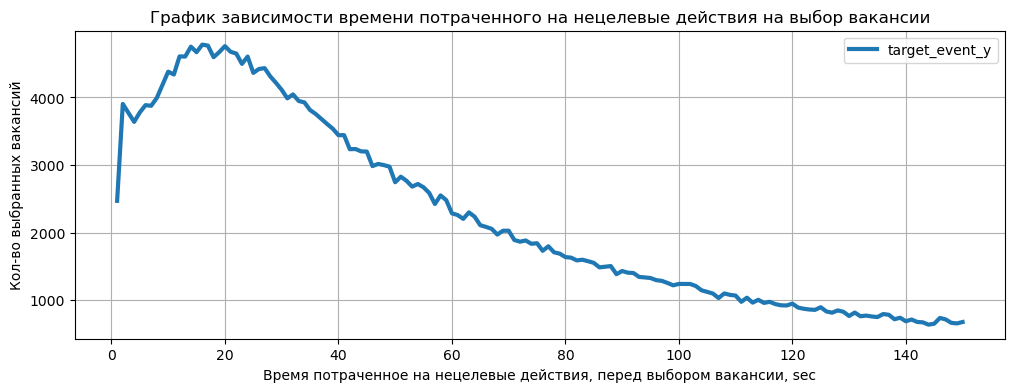

In [45]:
import matplotlib.pyplot as plt
lsd1[1:150].plot(
    kind='line',
    figsize=(12, 4),
    title='График зависимости времени потраченного на нецелевые действия на выбор вакансии',
    xlabel='Время потраченное на нецелевые действия, перед выбором вакансии, sec',
    ylabel='Кол-во выбранных вакансий',
    grid = True,
    lw=3
);

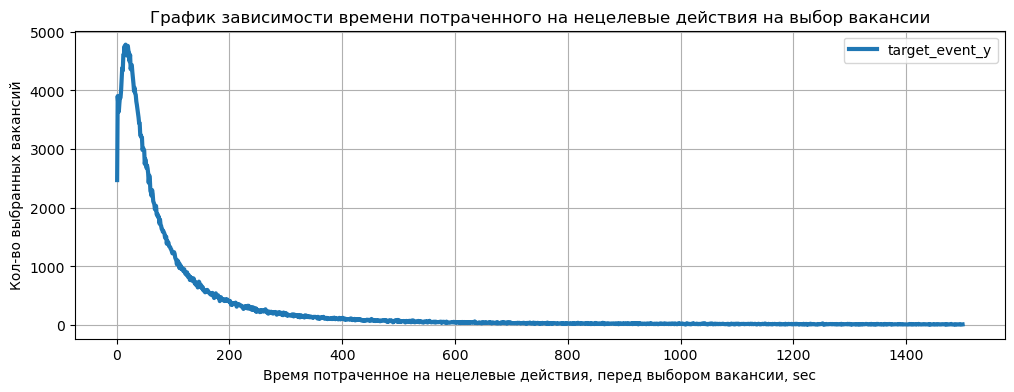

In [46]:
lsd1[1:1500].plot(
    kind='line',
    figsize=(12, 4),
    title='График зависимости времени потраченного на нецелевые действия на выбор вакансии',
    xlabel='Время потраченное на нецелевые действия, перед выбором вакансии, sec',
    ylabel='Кол-во выбранных вакансий',
    grid = True,
    lw=3
);